This notebook is a direct following of the previous [Parallel_STLaurentDeJourdes](Parallel_STLaurentDeJourdes.ipynb). Here are the hypothesis considered. 
* At the beginning of period k (or end of period k-1), one must compute a command $P_{inj}^i(k) \hspace{10px}\forall i \in {1, \ldots, N}$, where $N$ the total number of controllable Sgens in the network.

In [1]:
def printResults():
    colon = ':'
    print(f'P0100 prod, No Control   {colon:>7} {prod_no_curt_mwh[0]:.2f} MWh')
    print(f'P0100 prod, Future known {colon:>7} {prod_curt_perFuture_mwh:.2f} MWh  |  Perc = {prod_curt_perFuture_mwh*100/prod_no_curt_mwh[0]:.2f}%')
    print(f'P0100 prod, Persistence  {colon:>7} {prod_curt_pers_mwh:.2f} MWh  |  Perc = {prod_curt_pers_mwh*100/prod_no_curt_mwh[0]:.2f}%')

    for curr_period in h_start_end: 
        var1 = prod_curt_pers_iprv_mwh_dict[h2s(curr_period)]
        print(f'P0100, Per Impr {h2s(curr_period)} : {var1:.2f} MWh  |  Perc = {var1*100/prod_no_curt_mwh[0]:.2f}%')


In [2]:
#Import Modules 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandapower as pp
from pandapower.control.controller.const_control import ConstControl
from pandapower.timeseries.data_sources.frame_data import DFData
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.timeseries.output_writer import OutputWriter
from pandapower.plotting import simple_plot,simple_plotly,pf_res_plotly
import math as mt
import pandapower.plotting as pt
from pandapower.plotting.plotly import simple_plotly
from tqdm import tqdm # Profiling 
import seaborn as sbn
import time
import ipyparallel as ipp # Parallelization module
import pickle, sys, importlib


In [4]:
# import psutil
function_folder = 'py_files/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: sys.path.append(function_folder)

import myFunctions as mf
import myFunctions

from myFunctions import network_folder, excel_folder, py_folder, Δt, attr_list

In [5]:
#Import Networks
net_civaux=pp.from_pickle(f'{network_folder}CIVAUX.p')
net_stlaurent=pp.from_pickle(f'{network_folder}ST LAURENT.p')

##### Compute the totalpower  of BT prod and Load on St Laurent 


In [6]:
# Compute the total of BT prod and Load on St Laurent
sum_max_p_mw_StLaurent_prodBT =net_stlaurent.sgen[net_stlaurent.sgen.name.isna()].max_p_mw.sum()
sum_max_p_mw_StLaurent_load = net_stlaurent.load.max_p_mw.sum()

# To use later in functions 
sum_max_main_network = (sum_max_p_mw_StLaurent_prodBT, sum_max_p_mw_StLaurent_load)


Load variables from simulation done in [Parl_Real1_STLaurentDeJourdes](Parl_Real1_STLaurentDeJourdes.ipynb)

In [7]:
file_loc = 'pickle_files/simulationResults/'

with open(file_loc+"STLaurentDeJourdes_Par.pkl", 'rb') as file:
    STLaurentDeJourdes_Par_dict = pickle.load(file)
    
    
    
extracted_par_results_per = STLaurentDeJourdes_Par_dict['extracted_par_results_per']
df_sgen_HT = STLaurentDeJourdes_Par_dict['df_sgen_HT']
df_prodHT = STLaurentDeJourdes_Par_dict['df_prodHT']
df_prod_bt_total = STLaurentDeJourdes_Par_dict['df_prod_bt_total']
df_cons_total = STLaurentDeJourdes_Par_dict['df_cons_total']
max_vm_pu_NoControl_df = STLaurentDeJourdes_Par_dict['max_vm_pu_NoControl_df']
max_vm_pu_df = STLaurentDeJourdes_Par_dict['max_vm_pu_df']
max_vm_pu_per_df = STLaurentDeJourdes_Par_dict['max_vm_pu_per_df']
disdata = STLaurentDeJourdes_Par_dict['disdata']



# Create index to use for dataframe
per_index = pd.period_range('01 01 2020', periods=len(df_cons_total), freq='10T')


#### Plot Total prod BT and Total Load demand

In [8]:
net_civaux_hv_bus = list(net_civaux.bus.groupby('vn_kv'))[1][1] # Extract HV bus in the network

pp.runpp(net_civaux) # Run network 

# Get the index of all the activated bus in the network
activated_bus_index = list(net_civaux.res_bus.vm_pu[net_civaux.res_bus.vm_pu.notna()].index)

# Extract the HV bus from the list of activated bus 
net_civaux_hv_activated_bus = [i for i in activated_bus_index 
                               if i in net_civaux_hv_bus.index]

dict_df_sgenLoad = dict({'df_prodHT':df_prodHT, 
                         'df_prod_bt_total':df_prod_bt_total, 
                         'df_cons_total':df_cons_total } )

#### Create daylight period mask 

In [9]:
daylight_mask = (df_prodHT.P0013>0)|(df_prodHT.P0018>0)|(df_prodHT.P0100>0)|(df_prod_bt_total.Prod_BT>0)

#### Run Power flow for each instant

In [10]:
# Create elm for parallel running

n_engines = 7  # Total number of engines
# (Use the real maximum cpu and not the logical)            
cluster = ipp.Cluster(n=n_engines) # Create cluster
cluster.start_cluster_sync()       # Start cluster 
rc = cluster.connect_client_sync() # connect client
rc.wait_for_engines(n_engines)     # Wait for engines to be available for all clients
dview = rc[:]                      # Create a direct view of all engine or clients that would
                                   # be used to command each client

AttributeError: module 'ipyparallel' has no attribute 'Cluster'

In [276]:
def initializeParEngines_parameters(curr_period, dview, 
                                   parameters_dict, 
                                   sgenLoad_per_impr_dict, 
                                   per_index ): 
    
    h2s = lambda x : x[0]+' to '+x[1]
    
    
    dview.clear() # Clear the localspace of all engines

    # Add all  variables in the parameters_dict to  the local space of all engines
    dview.push(parameters_dict) 
                                
    # add the HT, BT prod and Load demand for the current persistence improved model
    # to the local space of all engines
    dview['dict_df_sgenLoad'] = sgenLoad_per_impr_dict[h2s(curr_period)]

    # Import following modules on the local space of clients or engines
    with rc[:].sync_imports():
        import numpy, pandapower,pandas, par_myFunctions, tqdm, importlib

    # Share the total number of period in df_prodHT.index among all the created engines
    dview.scatter('period_part', per_index[1:])

    

## Run optimal power flow 

In [14]:
net_civaux2=pp.from_pickle(f'{network_folder}CIVAUX.p') # Reload network with new name 

# Disable P0100
# net_civaux1.switch.loc[net_civaux1.switch.bus==7, 'closed'] = False 

# Add a controllable line to the static generators
net_civaux2.sgen['controllable'] = False 

# Set the producer P0100 as a controllable load
net_civaux2.sgen['controllable'][net_civaux2.sgen.name=='P0100'] = True

# Add Missing columns to be able to un an opf 
net_civaux2.sgen[['min_p_mw', 'min_q_mvar', 'max_q_mvar']]=0.

# Rename data in bus network because the names do not correspond to the parameters in pandapower 
net_civaux2.bus.rename({'max_vw_pu':'max_vm_pu',}, axis=1, inplace=True)

net_civaux2.bus.drop(['max_vm', 'min_vm'], axis=1, inplace=True)    # Delete useless parameters
net_civaux2_hv_bus = list(net_civaux2.bus.groupby('vn_kv'))[1][1]   # Extract HV bus in the network

# net_civaux2_hv_bus = net_civaux2_hv_bus[net_civaux1_hv_bus.max_vm_pu.notna()]

pp.runpp(net_civaux2) # Run network 

# Get the index of all the activated bus in the network
activated_bus_index2 = list(net_civaux2.res_bus.vm_pu[net_civaux2.res_bus.vm_pu.notna()].index)

# Extract the HV bus from the list of activated bus 
net_civaux2_hv_activated_bus = [i for i in activated_bus_index2 
                               if i in net_civaux2_hv_bus.index]

#### Add maximum voltage constraints on the Buses in the network 

In [15]:
vm_mu_max, vm_mu_min = 1.0225, 0.95  # Choose 

# net_civaux2.bus.max_vm_pu[net_civaux2.bus.max_vm_pu.notna()] = vm_mu_max
net_civaux2.bus.max_vm_pu[net_civaux2_hv_activated_bus] = vm_mu_max
net_civaux2.bus.min_vm_pu[net_civaux2_hv_activated_bus] = vm_mu_min

# Add negative cost to usability of sgen P0100 so its usage can be maximised while respecting the constraints on the network
cost_sgen_p0100 = pp.create_poly_cost(net_civaux2,23,'sgen', cp1_eur_per_mw=-1)
# net_civaux2.poly_cost.cp1_eur_per_mw.at[cost_sgen_p0100]=-0.5
net_civaux2.poly_cost

,element,et,cp0_eur,cp1_eur_per_mw,cp2_eur_per_mw2,cq0_eur,cq1_eur_per_mvar,cq2_eur_per_mvar2
0,23,sgen,0.0,-1.0,0.0,0.0,0.0,0.0


---

### Operation

In [38]:
prod_no_curt_mwh = df_prodHT.loc[daylight_mask,['P0100']].sum()*Δt  # P0100 energy production when not curtailed

prod_curt_perFuture_mw = np.array(df_sgen_HT.loc[daylight_mask,'P0100'])        # P0100 power production after curtailement
prod_curt_perFuture_mwh = prod_curt_perFuture_mw.sum(axis=0)*Δt                 # P0100 energy production after curtailed
prod_curt_perFuture_mw_df = pd.DataFrame(data=prod_curt_perFuture_mw, 
                                         index=per_index[daylight_mask])


prod_curt_pers_mw = np.array(df_sgen_HT.P0100_Persistence[1:][daylight_mask])  # P0100 power production after curtailement
prod_curt_pers_mwh = prod_curt_pers_mw.sum(axis=0)*Δt                          # P0100 energy production after curtailed
prod_curt_pers_mw_df = pd.DataFrame(data=prod_curt_pers_mw, 
                                    index=per_index[daylight_mask])

# Percentage of power not injected into the grid during the year considered
perc_not_injected_perFuture_mw = np.round((df_prodHT.loc[daylight_mask,'P0100']-prod_curt_perFuture_mw)*100/
                                          df_prodHT.loc[daylight_mask,'P0100'], decimals=2)
perc_not_injected_pers_mw = np.round((df_prodHT.loc[daylight_mask,'P0100']-prod_curt_pers_mw)*100/
                                     df_prodHT.loc[daylight_mask,'P0100'], decimals=2)

# Percentage of energy not injected into the grid during the year considered
perc_not_injected_perFuture_mwh = np.round((prod_no_curt_mwh-prod_curt_perFuture_mwh)*100/prod_no_curt_mwh, decimals=2)
perc_not_injected_pers_mwh      = np.round((prod_no_curt_mwh-prod_curt_pers_mwh)*100/prod_no_curt_mwh, decimals=2)


prod_curt_perFuture_mw_df[prod_curt_perFuture_mw_df<1e-6]=0 # replace lower value (lower than 1wh) by 0
prod_curt_pers_mw_df[prod_curt_perFuture_mw_df<1e-6]=0      # replace lower value (lower than 1wh) by 0

##### Define hour start and end for the improved persistence model

In [118]:
h_start_end = [['12:00','13:00'], ['11:00','14:00'],['11:00','15:00'], ['10:00','15:00'] ]

hour2String = lambda x : x[0]+' to '+x[1]

##### Run the improved persistance for each period defined above

In [120]:
# Extract result and save in a df
results_per_iprv_dict = {}
name_p = 'Pers_imprv '

for curr_period in h_start_end: 
    results_per_iprv,__ = mf.improve_persinstence(extracted_par_results_per, df_prodHT, vm_mu_max, curr_period)
    results_per_iprv_dict.update({hour2String(curr_period):results_per_iprv})


    # Get injected PV production for all (3) HT producers
    df_sgen_HT_per_iprv = results_per_iprv.iloc[:,-3:]
    
    # Add result to existing DF and implement bloc PROD
    name2use= name_p + hour2String(curr_period)    # Define name to use
    df_sgen_HT[name2use] = np.nan;
    df_sgen_HT[name2use][1:] = np.minimum(df_sgen_HT.P0100_No_Control[1:], df_sgen_HT_per_iprv.P0100[:-1])

In [101]:
df_sgen_HT.rename(columns={'P0100':'P0100 FtrKnown'}, inplace=True)
# df_sgen_HT.drop(columns=df_sgen_HT.columns[5:],inplace=True)

<AxesSubplot:>

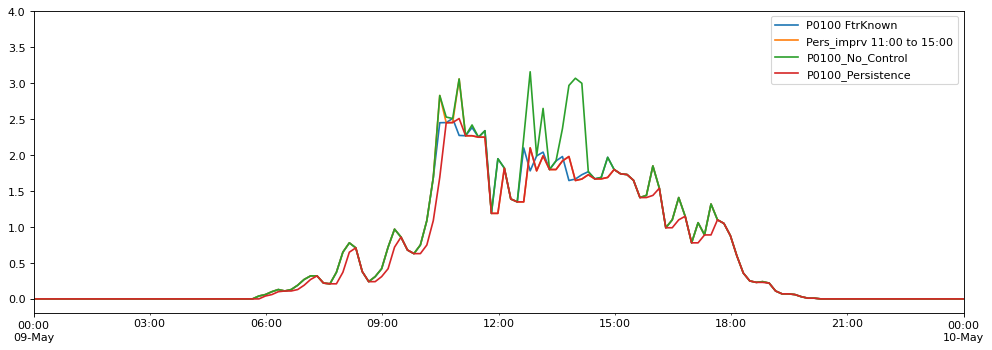

In [563]:
fig, axx = plt.subplots(figsize=(15,5), dpi=80)
# df_prodHT[['P0100']].plot( ax=axx)
df_sgen_HT[['P0100 FtrKnown','Pers_imprv 11:00 to 15:00', 'P0100_No_Control', 'P0100_Persistence']].plot(xlim=('2020 05 09', '2020 05 10'), ax=axx)


In [564]:
h2s = hour2String
# " Production curtailed using Persistence improved in mW : dictionnary"
prod_curt_pers_iprv_mw_dict, prod_curt_pers_iprv_mwh_dict, prod_curt_pers_iprv_mw_df = {},{},{}
perc_not_injected_pers_iprv_mw_dict, perc_not_injected_pers_iprv_mwh_dict = {},{}

 
for curr_period in h_start_end:
    name2use= name_p + h2s(curr_period)
    # Add the persistence improved Power result to the dictionnary
    prod_curt_pers_iprv_mw_dict.update({ h2s(curr_period): df_sgen_HT[name2use][1:][daylight_mask]})
    
    # Add the persistence improved  Energy result to the dictionnary
    prod_curt_pers_iprv_mwh_dict.update({h2s(curr_period): prod_curt_pers_iprv_mw_dict[h2s(curr_period)].sum(axis=0)*Δt  })
    
    # Save the persistence improved power in a dataframe and save the created df in a dict
    int_df = pd.DataFrame(data = prod_curt_pers_iprv_mw_dict[h2s(curr_period)], index=per_index[daylight_mask])
    int_df[int_df<1e-6] = 0 # replace lower value (lower than 1w) by 0
    prod_curt_pers_iprv_mw_df.update({h2s(name2use):int_df})
    
    # Percentage of power not injected into the grid during the year considered
    int_var = np.round((df_prodHT.loc[daylight_mask,'P0100']-prod_curt_pers_iprv_mw_dict[h2s(curr_period)])*100/
                        df_prodHT.loc[daylight_mask,'P0100'], decimals=2)
    perc_not_injected_pers_iprv_mw_dict.update({h2s(curr_period): int_var})
    
    # Percentage of energy not injected into the grid during the year considered
    int_var = np.round((prod_no_curt_mwh-prod_curt_pers_iprv_mwh_dict[h2s(curr_period)])*100/prod_no_curt_mwh, decimals=2)
    perc_not_injected_pers_iprv_mwh_dict.update({h2s(curr_period):int_var })
    

In [565]:
printResults()

P0100 prod, No Control         : 5033.34 MWh
P0100 prod, Future known       : 4717.39 MWh  |  Perc = 93.72%
P0100 prod, Persistence        : 4365.56 MWh  |  Perc = 86.73%
P0100, Per Impr 12:00 to 13:00 : 4705.19 MWh  |  Perc = 93.48%
P0100, Per Impr 11:00 to 14:00 : 4619.33 MWh  |  Perc = 91.77%
P0100, Per Impr 11:00 to 15:00 : 4581.19 MWh  |  Perc = 91.02%
P0100, Per Impr 10:00 to 15:00 : 4535.79 MWh  |  Perc = 90.12%


#### Initialize data to use by each parallel engine

In [274]:
# Create a dict to store load, and production for each type of persitence improved used
sgenLoad_per_impr_dict = {}

for curr_period in h_start_end:
    name2use= name_p + h2s(curr_period)
    int_var = dict({'df_prodHT':df_sgen_HT[['P0013', 'P0018', name2use,]][1:], 
                    'df_prod_bt_total':df_prod_bt_total, 
                    'df_cons_total':df_cons_total } )
    
    sgenLoad_per_impr_dict.update({h2s(curr_period): int_var}) 
    
    
    
# Create a dictionnary containing all the varible that will be used by each client or engine
opf_status = False 
pred_model = 'Pers'
parameters_dict = dict({'net_civaux2':net_civaux2, 
                        'net_civaux2_hv_activated_bus':net_civaux2_hv_activated_bus, 
                        'sum_max_main_network':sum_max_main_network, 
                        'vm_mu_max':vm_mu_max,
                        'opf_status':opf_status, 
                        'pred_model': pred_model})


#### Run optimal power flow on all engines

In [277]:
max_vm_pu_per_imprv_df_dict = {}

for curr_period in h_start_end:
    
    print('*********  Current simulation being done is', curr_period, '*********')

    initializeParEngines_parameters(curr_period, dview, 
                                   parameters_dict, 
                                   sgenLoad_per_impr_dict, 
                                   per_index)
    
    # Run par_myFunctions in all engines
    %px resulting_pf_per_imprv = [par_myFunctions.run_powerflow_at(net_civaux2, cur_period, net_civaux2_hv_activated_bus, sum_max_main_network, dict_df_sgenLoad, vm_mu_max, opf_status) for cur_period in period_part]

    # dview.wait(5)
    # Gather the result of each engine in a single list
    par_results_list = dview.gather('resulting_pf_per_imprv')
    
    time.sleep(10) # Wait before continuing the execution
    
    name2use= name_p + h2s(curr_period)
    max_vm_pu_per_imprv_df_dict.update( {name2use: np.array(par_results_list) })

    print('\n')
    

*********  Current simulation being done is ['12:00', '13:00'] *********
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing par_myFunctions on engine(s)
importing tqdm on engine(s)
importing importlib on engine(s)


%px:   0%|          | 0/7 [00:00<?, ?tasks/s]



*********  Current simulation being done is ['11:00', '14:00'] *********
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing par_myFunctions on engine(s)
importing tqdm on engine(s)
importing importlib on engine(s)


%px:   0%|          | 0/7 [00:00<?, ?tasks/s]



*********  Current simulation being done is ['11:00', '15:00'] *********
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing par_myFunctions on engine(s)
importing tqdm on engine(s)
importing importlib on engine(s)


%px:   0%|          | 0/7 [00:00<?, ?tasks/s]



*********  Current simulation being done is ['10:00', '15:00'] *********
importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing par_myFunctions on engine(s)
importing tqdm on engine(s)
importing importlib on engine(s)


%px:   0%|          | 0/7 [00:00<?, ?tasks/s]

In [278]:
# Put data in dataframe
max_vm_pu_per_imprv_df = pd.DataFrame(data=max_vm_pu_per_imprv_df_dict, index=per_index[1:])



Text(0.5, 1.0, 'Maximum voltage on all buses in the network')

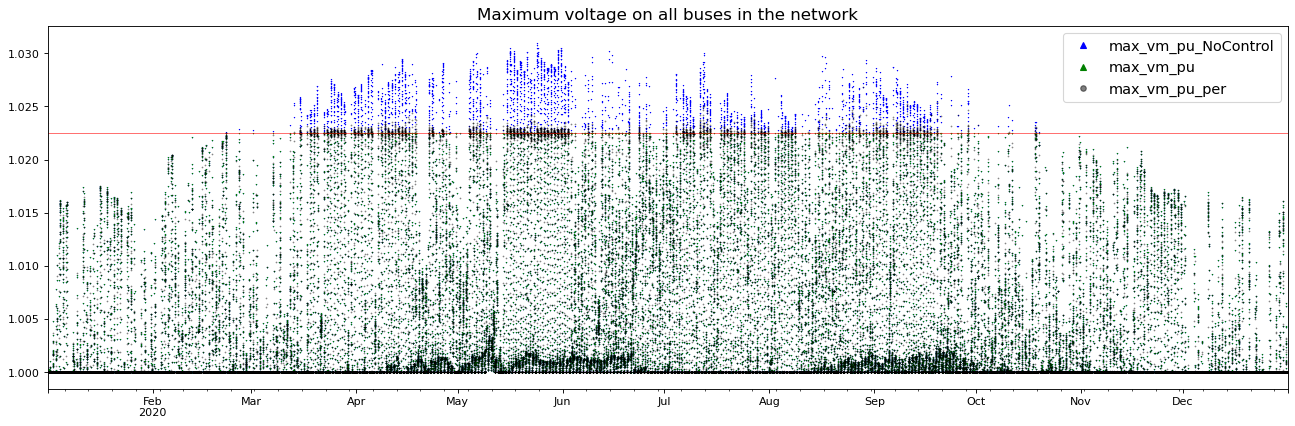

In [520]:
fig, axx = plt.subplots(figsize=(20,6), dpi=80)
max_vm_pu_NoControl_df.plot(ax=axx, style='b^',  markersize=0.5)
max_vm_pu_df.plot(ax=axx, style='g^', markersize=0.5)
max_vm_pu_per_df.plot(ax=axx, style='ko', markersize=0.5, alpha=0.5)
# max_vm_pu_per_imprv_df.plot(ax=axx, style='o', markersize=0.5, alpha=1)

# aa.plot(ax=axx, style=['^','*','o'],color=['b','g','k'], markersize=0.5)

plt.axhline(vm_mu_max,color='r', lw=0.5)
# plt.ylabel('max_vm_pu', fontsize=13)
# plt.legend(['No Control','Future known', 'Persistence', 'Persistence improve' ],fontsize=13, markerscale=10)
plt.legend(fontsize=13, markerscale=10)

plt.title("Maximum voltage on all buses in the network",fontsize=15,)
# plt.xlim(['2020 05 01', '2020 05 10']);
# plt.ylim(1.020,1.030)

In [548]:
pers_df = pd.concat([max_vm_pu_per_imprv_df, max_vm_pu_per_df], axis=1)
pers_df.rename(columns={'max_vm_pu_per':'Persistence'}, inplace=True);

P0100 prod, No Control         : 5033.34 MWh
P0100 prod, Future known       : 4717.39 MWh  |  Perc = 93.72%
P0100 prod, Persistence        : 4365.56 MWh  |  Perc = 86.73%
P0100, Per Impr 12:00 to 13:00 : 4705.19 MWh  |  Perc = 93.48%
P0100, Per Impr 11:00 to 14:00 : 4619.33 MWh  |  Perc = 91.77%
P0100, Per Impr 11:00 to 15:00 : 4581.19 MWh  |  Perc = 91.02%
P0100, Per Impr 10:00 to 15:00 : 4535.79 MWh  |  Perc = 90.12%


Text(0.5, 1.0, 'Multivariate Histogram of voltage rise above the authorised threshold')

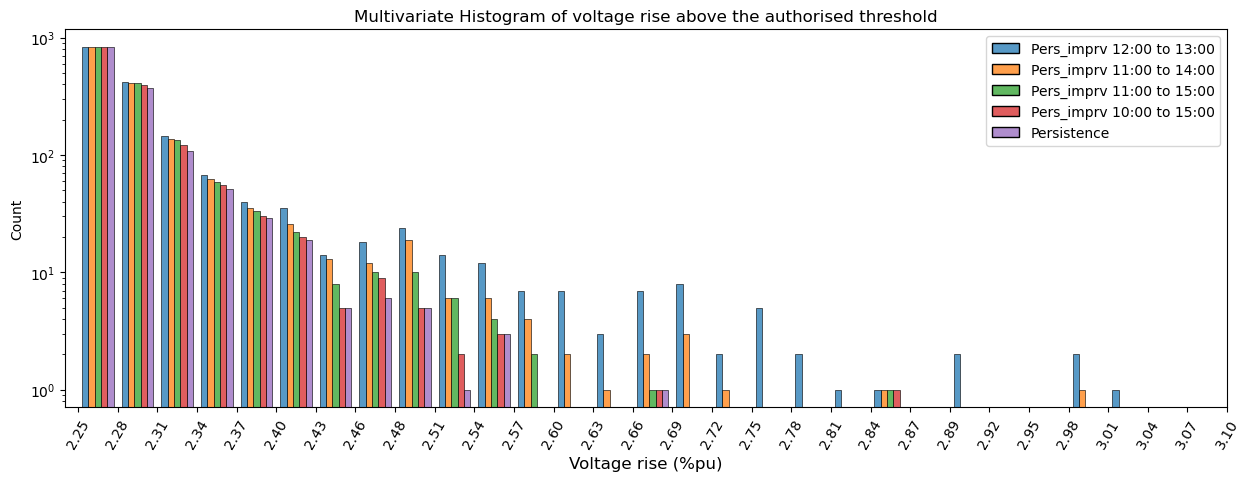

In [584]:
printResults()

fig, axx = plt.subplots(figsize=(15,5), dpi=100)

nb_points = 30
laabel = [f'{elm:.2f}' for elm in np.linspace(2.25, 3.1, nb_points)]
tiicks = np.linspace(1.0225, 1.031, nb_points)

sbn.histplot(pers_df, ax=axx, 
             bins=(nb_points-1), 
             binrange=(1.0225,1.0310),
             stat='count', multiple='dodge', shrink = 0.8, )

axx.set_xticks(tiicks, labels=laabel, rotation=60);
plt.xlabel('Voltage rise (%pu)',fontsize=12);
axx.set(xlim=(1.0224,1.031))
# fig.legend(handleheight=0.5)
axx.semilogy()
plt.title('Multivariate Histogram of voltage rise above the authorised threshold')

In [645]:
list(perc_not_injected_pers_iprv_mw_dict.keys())

['12:00 to 13:00', '11:00 to 14:00', '11:00 to 15:00', '10:00 to 15:00']

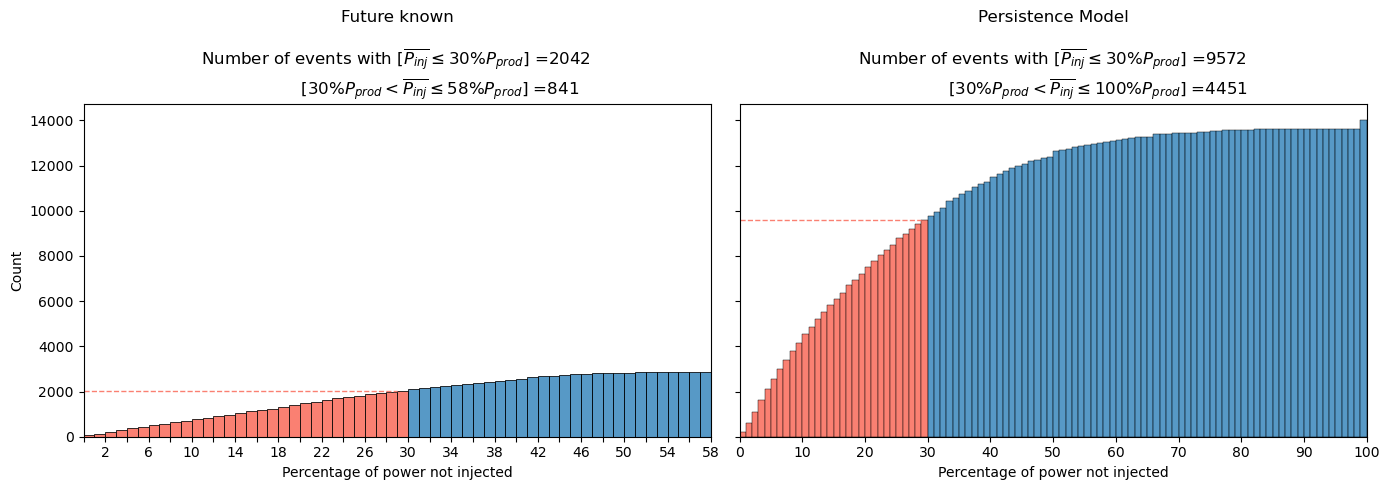

In [596]:
statt = 'count'
tick_lab = [i if elm%2==1 else '' for elm, i  in enumerate(range(0,60,2)) ]

fig, axx = plt.subplots(1,2, figsize=(14,5), dpi=100, sharey=True)

sbn.histplot(perc_not_injected_perFuture_mw[perc_not_injected_perFuture_mw>0],bins=58, binrange=[0,58],
             stat=statt, ax=axx[0], cumulative=True,
             legend=False, )

sbn.histplot(perc_not_injected_pers_mw[perc_not_injected_pers_mw>0],bins=100, binrange=[0,100],
             stat=statt, ax=axx[1], cumulative=True,
             legend=False, )


perc_to_consider= 30
perc_to_consider2= 30
for elm in axx[0].patches[:perc_to_consider]: elm.set_facecolor('salmon')
for elm in axx[1].patches[:perc_to_consider2]: elm.set_facecolor('salmon')

var1 = axx[0].patches[perc_to_consider-1].get_height()
var2 = axx[0].patches[-1].get_height() - var1 
axx[0].set(xlabel='Percentage of power not injected',
           title=(f'Future known\n\n'
               f'Number of events with [$\\overline{{P_{{inj}} }}\leq ${perc_to_consider2}%$P_{{prod}}$] ={var1} \n'
               f'\t\t[${perc_to_consider2}\%P_{{prod}} < \\overline{{P_{{inj}} }}\leq 58\% P_{{prod}}$] ={var2}'),
           xlim=(0,58),
           xticks=range(0,60,2),
           xticklabels=tick_lab);

var1 = axx[1].patches[perc_to_consider2-1].get_height()
var2 = axx[1].patches[-1].get_height() - var1 
axx[1].set(xlabel='Percentage of power not injected',
           xticks=range(0,105,10),
           title=(f'Persistence Model\n\n'
               f'Number of events with [$\\overline{{P_{{inj}} }}\leq ${perc_to_consider2}%$P_{{prod}}$] ={var1} \n'
               f' \t\t [${perc_to_consider2}\%P_{{prod}} < \\overline{{P_{{inj}} }}\leq 100\% P_{{prod}}$] ={var2}'),
           xlim=(0,100),
        );


x_maxx = axx[0].patches[perc_to_consider-1].get_x()/58
axx[0].axhline(axx[0].patches[perc_to_consider-1].get_height(),xmax=x_maxx, color='salmon', ls='--', lw=1)

x_maxx = axx[1].patches[perc_to_consider2-1].get_x()/100
axx[1].axhline(axx[1].patches[perc_to_consider2-1].get_height(),xmax=x_maxx, color='salmon', ls='--', lw=1)


fig.tight_layout()

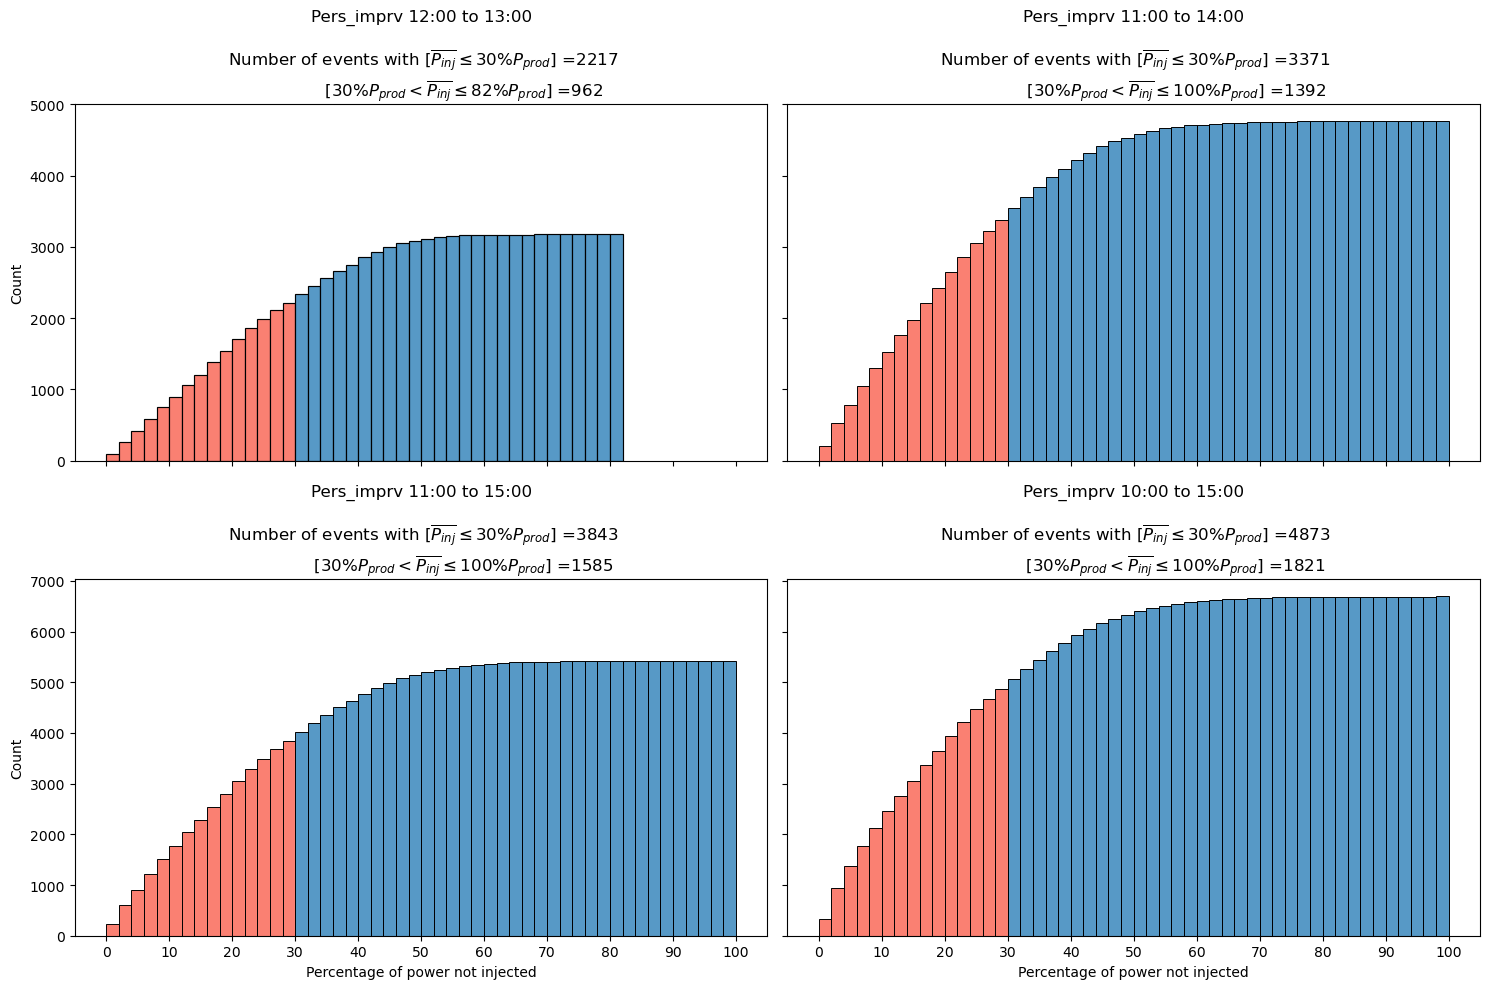

Controller stopped: {'exit_code': 1, 'pid': 13184, 'identifier': 'ipcontroller-1662709034-h63u-9144'}
engine set stopped 1662709035: {'engines': {'0': {'exit_code': 1, 'pid': 24624, 'identifier': '0'}, '1': {'exit_code': 1, 'pid': 28264, 'identifier': '1'}, '2': {'exit_code': 1, 'pid': 12684, 'identifier': '2'}, '3': {'exit_code': 1, 'pid': 22740, 'identifier': '3'}, '4': {'exit_code': 1, 'pid': 22784, 'identifier': '4'}, '5': {'exit_code': 1, 'pid': 6060, 'identifier': '5'}, '6': {'exit_code': 1, 'pid': 28432, 'identifier': '6'}}, 'exit_code': 1}


In [712]:
nb_points = 25
perc_to_consider= 15

# laabel = [f'{elm:.2f}' for elm in np.linspace(2.25, 3.1, nb_points)]
tiicks = range(0,101,10)

fig, axx =plt.subplots(2,2,figsize= (15,10), sharey='row', sharex=True, dpi=100)
for cur_ax, elm_nb in zip(axx.flatten(), range(4)):
    keys_list = list(perc_not_injected_pers_iprv_mw_dict.keys())
    cur_var = perc_not_injected_pers_iprv_mw_dict[keys_list[elm_nb]]
    
    cur_var=cur_var[cur_var>vm_mu_max]
    binRange, n_bins, bin_end= [0,100], 50, 100
    if elm_nb == 0 : binRange, n_bins, bin_end =[0,82], 41, 82
    sbn.histplot(data=cur_var, ax=cur_ax, 
                 cumulative=True,  stat='count', bins=n_bins, binrange=binRange)
    cur_ax.set_xticks(tiicks,);
    # cur_ax.set(xlabel='', title=pers_df.columns[elm_nb])

    for elm in cur_ax.patches[:perc_to_consider]: elm.set_facecolor('salmon')

    var1 = cur_ax.patches[perc_to_consider-1].get_height()
    var2 = cur_ax.patches[-1].get_height() - var1 
    cur_ax.set(xlabel='Percentage of power not injected',
           title=(f'{pers_df.columns[elm_nb]}\n\n '
               f'Number of events with [$\\overline{{P_{{inj}} }}\leq ${perc_to_consider2}%$P_{{prod}}$] ={var1} \n'
               f'\t\t[${perc_to_consider2}\%P_{{prod}} < \\overline{{P_{{inj}} }}\leq {bin_end}\% P_{{prod}}$] ={var2}'),);
fig.tight_layout()